In [11]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers.experimental import RandomFourierFeatures
#from imgaug import augmenters as iaa

import keras
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import Dropout, Dense, Input, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Layer, Conv2D, Flatten, BatchNormalization, Concatenate, Multiply, Average
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model

# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) `tensorflow` random seed
# 3) `python` random seed
keras.utils.set_random_seed(812)

# This will make TensorFlow ops as deterministic as possible, but it will
# affect the overall performance, so it's not enabled by default.
# `enable_op_determinism()` is introduced in TensorFlow 2.9.
tf.config.experimental.enable_op_determinism()

In [12]:
# Auxiliary function for data distribution visualization
def data_visualization(classes, data):

    fig, ax = plt.subplots(figsize=(9, 5))
    ax.bar(classes, data)
    ax.set(title="Dataset's distribution for each class")
    ax.set(xlabel="Classes", ylabel="#Images");
    # Rotate x-axis labels by 45 degrees
    plt.xticks(rotation=45)
    ax.grid()
    
def apply_clahe(img):
    """
    Apply Contrast Limited Adaptive Histogram Equalization (CLAHE) to enhance image contrast.

    Parameters:
    - img: NumPy array, input RGB image.

    Returns:
    - Image after applying CLAHE for enhanced contrast.
    """
    
    # Split the RGB image into individual channels
    rgb_planes = cv2.split(img)

    # Create a CLAHE object with a clip limit of 5.0
    clahe = cv2.createCLAHE(clipLimit=5.0)

    # Apply CLAHE to each channel separately
    r = clahe.apply(rgb_planes[0])
    g = clahe.apply(rgb_planes[1])
    b = clahe.apply(rgb_planes[2])

    # Merge the processed channels to obtain the final image
    img = cv2.merge([r, g, b])

    return img

def load_data(data_path, image_size):

    subfolders = ['No DR', 'Mild NPDR', 'Moderate NPDR', 'Severe NPDR', 'Very Severe NPDR', 'PDR', 'Advanced PDR']

    print("[INFO] Dataset Loading...\n")

    img_data_list=[]
    labels_list = []
    num_images_per_class = []

    for category in subfolders:
        img_list=os.listdir(data_path +'/'+ category)
        if("Annotations" in category):
            continue
        
        print('Loading :', len(img_list), 'images of category: ', category)
        for img in img_list:
            # Load an image from this path
            img_path = data_path + '/'+ category + '/'+ img
            # Read the image from the specified path
            img = cv2.imread(img_path)
            # Convert the image from BGR to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #pixels = apply_clahe(img)
            img_array=cv2.resize(img, (image_size[0],image_size[1]), fx=1, fy=1,interpolation = cv2.INTER_CUBIC)        
            img_data_list.append(img_array) 
            labels_list.append(category)
        num_images_per_class.append(len(img_list))

    le = LabelEncoder()
    labels = le.fit_transform(labels_list)
    labels = to_categorical(labels)
    data = np.array(img_data_list)
    
    data_visualization(subfolders, num_images_per_class)

    # Dataset Summary
    print("\nTotal number of uploaded data: ", data.shape[0],
          ", with data shape", (data.shape[1],data.shape[2],data.shape[3]))

    return data, labels

[INFO] Dataset Loading...

Loading : 187 images of category:  No DR
Loading : 4 images of category:  Mild NPDR
Loading : 80 images of category:  Moderate NPDR
Loading : 176 images of category:  Severe NPDR
Loading : 108 images of category:  Very Severe NPDR
Loading : 88 images of category:  PDR
Loading : 114 images of category:  Advanced PDR

Total number of uploaded data:  757 , with data shape (512, 512, 3)


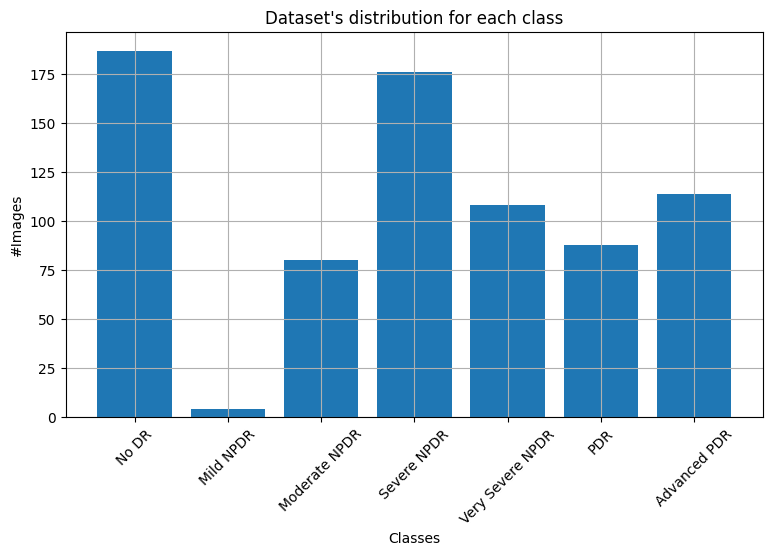

In [13]:
image_size = (512,512,3)
input_shape = image_size
data_path = "/kaggle/input/zenodo-dr7/Zenodo-DR7"
data, labels = load_data(data_path,image_size)

In [14]:
# Split the dataset into two subsets (80%-20%). The first one will be used for training.
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=195, stratify=labels)

print(f"X_train has shape: {X_train.shape}")
print(f"y_train has shape: {y_train.shape}\n")

print(f"X_test has shape: {X_test.shape}")
print(f"y_test has shape: {y_test.shape}\n")

print(f"X_train + X_test = {X_train.shape[0] + X_test.shape[0]} samples in total")

X_train has shape: (605, 512, 512, 3)
y_train has shape: (605, 7)

X_test has shape: (152, 512, 512, 3)
y_test has shape: (152, 7)

X_train + X_test = 757 samples in total


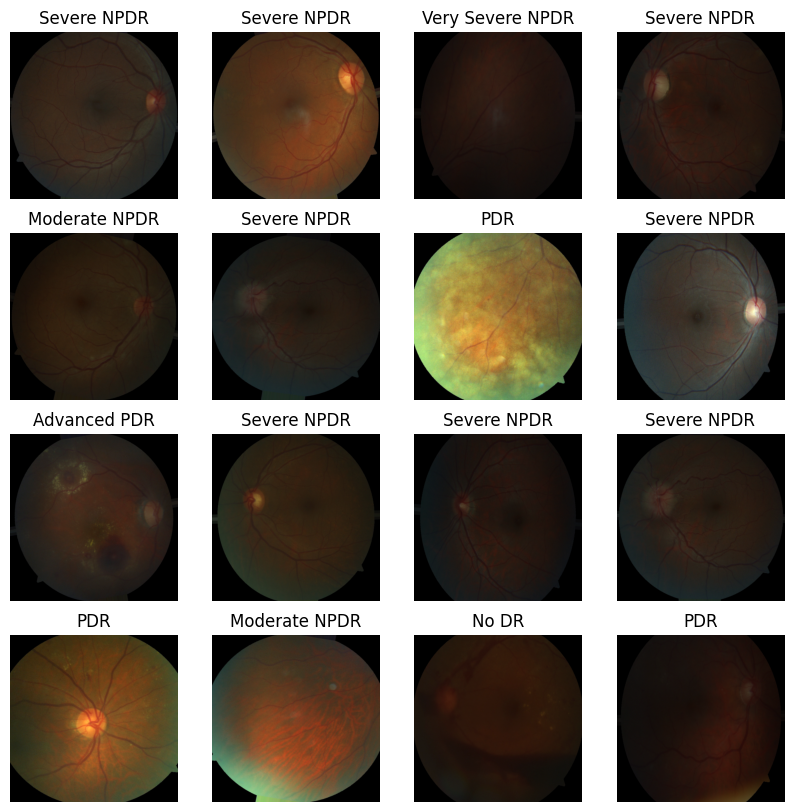

In [15]:
# Map the disease categories
mapping = {0: 'No DR', 1: 'Mild NPDR', 2: 'Moderate NPDR', 3:'Severe NPDR', 4:'Very Severe NPDR', 5: 'PDR', 6:'Advanced PDR'}

# Initialize the training data augmentation object
trainAug = ImageDataGenerator(rotation_range=15,
                              zoom_range=0.15,
                              #width_shift_range=0.2,
                              brightness_range=(.6, 1.2),
                              shear_range=.15,
                              #height_shift_range=0.2,
                              horizontal_flip=True,
                              fill_mode="nearest")

# Randomly vizualize some augmented samples
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(trainAug.flow(X_train, y_train, batch_size=1)):
    if i == 16:
        break

    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(np.squeeze(image)/255.)
    plt.title(mapping[np.argmax(label)])
    plt.axis("off")

In [16]:
from keras.layers import Conv1D, Conv2D, Conv3D
from keras.layers import Reshape
from keras.layers import Activation
from keras.layers import Softmax
from keras.layers import Permute
from keras.layers import add, dot

from keras import backend as K


def GlobalContextAttention(ip, reduction_ratio=8, transform_activation='linear'):
    """
    Adds a Global Context attention block for self attention to the input tensor.
    Input tensor can be or rank 3 (temporal), 4 (spatial) or 5 (spatio-temporal).

    # Arguments:
        ip: input tensor
        intermediate_dim: The dimension of the intermediate representation. Can be
            `None` or a positive integer greater than 0. If `None`, computes the
            intermediate dimension as half of the input channel dimension.
        reduction_ratio: Reduces the input filters by this factor for the
            bottleneck block of the transform submodule. Node: the reduction
            ratio must be set such that it divides the input number of channels,
        transform_activation: activation function to apply to the output
            of the transform block. Can be any string activation function availahle
            to Keras.

    # Returns:
        a tensor of same shape as input
    """
    channel_dim = 1 if K.image_data_format() == 'channels_first' else -1
    ip_shape = K.int_shape(ip)

    # check rank and calculate the input shape
    if len(ip_shape) == 3:  # temporal / time series data
        rank = 3
        batchsize, dim1, channels = ip_shape

    elif len(ip_shape) == 4:  # spatial / image data
        rank = 4

        if channel_dim == 1:
            batchsize, channels, dim1, dim2 = ip_shape
        else:
            batchsize, dim1, dim2, channels = ip_shape

    elif len(ip_shape) == 5:  # spatio-temporal / Video or Voxel data
        rank = 5

        if channel_dim == 1:
            batchsize, channels, dim1, dim2, dim3 = ip_shape
        else:
            batchsize, dim1, dim2, dim3, channels = ip_shape

    else:
        raise ValueError('Input dimension has to be either 3 (temporal), 4 (spatial) or 5 (spatio-temporal)')

    if rank > 3:
        flat_spatial_dim = -1 if K.image_data_format() == 'channels_first' else 1
    else:
        flat_spatial_dim = 1

    """ Context Modelling Block """
    # [B, ***, C] or [B, C, ***]
    input_flat = _spatial_flattenND(ip, rank)
    # [B, ..., C] or [B, C, ...]
    context = _convND(ip, rank, channels=1, kernel=1)
    # [B, ..., 1] or [B, 1, ...]
    context = _spatial_flattenND(context, rank)
    # [B, ***, 1] or [B, 1, ***]
    context = Softmax(axis=flat_spatial_dim)(context)

    # Compute context block outputs
    context = dot([input_flat, context], axes=flat_spatial_dim)
    # [B, C, 1]
    context = _spatial_expandND(context, rank)
    # [B, C, 1...] or [B, 1..., C]

    """ Transform block """
    # Transform bottleneck
    # [B, C // R, 1...] or [B, 1..., C // R]
    transform = _convND(context, rank, channels // reduction_ratio, kernel=1)
    # Group normalization acts as Layer Normalization when groups = 1
    #transform = GroupNormalization(groups=1, axis=channel_dim)(transform)
    transform = Activation('relu')(transform)

    # Transform output block
    # [B, C, 1...] or [B, 1..., C]
    transform = _convND(transform, rank, channels, kernel=1)
    transform = Activation(transform_activation)(transform)

    # apply context transform
    out = add([ip, transform])

    return out


def _convND(ip, rank, channels, kernel=1):
    assert rank in [3, 4, 5], "Rank of input must be 3, 4 or 5"

    if rank == 3:
        x = Conv1D(channels, kernel, padding='same', use_bias=False, kernel_initializer='he_normal')(ip)
    elif rank == 4:
        x = Conv2D(channels, (kernel, kernel), padding='same', use_bias=False, kernel_initializer='he_normal')(ip)
    else:
        x = Conv3D(channels, (kernel, kernel, kernel), padding='same', use_bias=False, kernel_initializer='he_normal')(ip)

    return x


def _spatial_flattenND(ip, rank):
    assert rank in [3, 4, 5], "Rank of input must be 3, 4 or 5"

    ip_shape = K.int_shape(ip)
    channel_dim = 1 if K.image_data_format() == 'channels_first' else -1

    if rank == 3:
        x = ip  # identity op for rank 3

    elif rank == 4:
        if channel_dim == 1:
            # [C, D1, D2] -> [C, D1 * D2]
            shape = [ip_shape[1], ip_shape[2] * ip_shape[3]]
        else:
            # [D1, D2, C] -> [D1 * D2, C]
            shape = [ip_shape[1] * ip_shape[2], ip_shape[3]]

        x = Reshape(shape)(ip)

    else:
        if channel_dim == 1:
            # [C, D1, D2, D3] -> [C, D1 * D2 * D3]
            shape = [ip_shape[1], ip_shape[2] * ip_shape[3] * ip_shape[4]]
        else:
            # [D1, D2, D3, C] -> [D1 * D2 * D3, C]
            shape = [ip_shape[1] * ip_shape[2] * ip_shape[3], ip_shape[4]]

        x = Reshape(shape)(ip)

    return x


def _spatial_expandND(ip, rank):
    assert rank in [3, 4, 5], "Rank of input must be 3, 4 or 5"

    channel_dim = 1 if K.image_data_format() == 'channels_first' else -1

    if rank == 3:
        x = Permute((2, 1))(ip)  # identity op for rank 3

    elif rank == 4:
        if channel_dim == 1:
            # [C, D1, D2] -> [C, D1 * D2]
            shape = [-1, 1, 1]
        else:
            # [D1, D2, C] -> [D1 * D2, C]
            shape = [1, 1, -1]

        x = Reshape(shape)(ip)

    else:
        if channel_dim == 1:
            # [C, D1, D2, D3] -> [C, D1 * D2 * D3]
            shape = [-1, 1, 1, 1]
        else:
            # [D1, D2, D3, C] -> [D1 * D2 * D3, C]
            shape = [1, 1, 1, -1]

        x = Reshape(shape)(ip)

    return x

In [17]:
from keras.layers import Conv2D, LayerNormalization

class AttentionGate(Layer):
    def __init__(self, filters, **kwargs):
        self.filters = filters
        super(AttentionGate, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create trainable parameters for attention gate
        self.conv_xl = Conv2D(self.filters, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu')
        self.conv_g = Conv2D(self.filters, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu')
        self.psi = Conv2D(1, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='linear')
        self.layer_norm = LayerNormalization(axis=-1)
        self.bxg = self.add_weight(name='bxg',
                                  shape=(self.filters,),
                                  initializer='zeros',
                                  trainable=True)
        self.bpsi = self.add_weight(name='bpsi',
                                   shape=(1,),
                                   initializer='zeros',
                                   trainable=True)
        super(AttentionGate, self).build(input_shape)

    def call(self, inputs):
        xl, g = inputs

        # Apply convolutional operations
        xl_conv = self.conv_xl(xl)
        g_conv = self.conv_g(g)

        # Compute additive attention
        att = K.relu(xl_conv + g_conv + self.bxg)
        att = self.layer_norm(att)  # Add LayerNormalization
        att = self.psi(att) + self.bpsi
        att = K.sigmoid(att)

        # Apply attention gate
        x_hat = att * xl

        return x_hat

    def compute_output_shape(self, input_shape):
        return input_shape[0]

In [18]:
import tensorflow as tf
from keras.optimizers import RMSprop
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16

class GCRMSprop(RMSprop):
    def get_gradients(self, loss, params):
        # We here just provide a modified get_gradients() function since we are
        # trying to just compute the centralized gradients.

        grads = []
        gradients = super().get_gradients()
        for grad in gradients:
            grad_len = len(grad.shape)
            if grad_len > 1:
                axis = list(range(grad_len - 1))
                grad -= ops.mean(grad, axis=axis, keep_dims=True)
            grads.append(grad)

        return grads
    
optimizer = GCRMSprop(learning_rate=1e-4)

# Build the model
def build_model(input_shape, num_classes):
    base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=input_shape)
    #for layer in base_model.layers:
    #    layer.trainable = False

    fmaps = base_model.output # .get_layer('block5_pool')
    context_fmaps = GlobalContextAttention(fmaps)
    att_fmaps = AttentionGate(fmaps.shape[-1])([fmaps, context_fmaps])
    x = layers.GlobalAveragePooling2D()(att_fmaps)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model(input_shape, num_classes=7)

In [19]:
from contextlib import redirect_stdout

with open('modelsummary.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary()

print(model.summary())
#plot_model(model, show_shapes=True, to_file='model.png')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 512, 512, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 512, 512, 3)          0         ['rescaling_1[0][0]']         
 tion)                                                                                            
                                                                                                  
 stem_conv (Conv2D)          (None, 256, 256, 32)         864       ['normalization_1[0][0]'

In [20]:
EPOCHS = 100
batch_size = 32
model_path = "/kaggle/working/weights.best.hdf5"

# Define the necessary callbacks
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystopping = EarlyStopping(monitor='val_accuracy', patience=15, verbose=1, mode='auto', restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-6, verbose=1)

callbacks = [checkpoint] #earlystopping, rlrop

print(f"[INFO] training network for {EPOCHS} epochs...\n")
hist = model.fit(X_train, y_train, batch_size=batch_size,
                 validation_data=(X_test, y_test),
                 epochs=EPOCHS, callbacks=callbacks)

[INFO] training network for 100 epochs...

Epoch 1/100


2024-01-12 14:49:01.585244: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


19/19 [==============================] - ETA: 0s - loss: 1.6294 - accuracy: 0.4364
Epoch 1: val_accuracy improved from -inf to 0.42763, saving model to /kaggle/working/weights.best.hdf5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


19/19 [==============================] - 51s 775ms/step - loss: 1.6294 - accuracy: 0.4364 - val_loss: 1.5162 - val_accuracy: 0.4276
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 1.2229 - accuracy: 0.5934
Epoch 2: val_accuracy improved from 0.42763 to 0.61184, saving model to /kaggle/working/weights.best.hdf5
19/19 [==============================] - 12s 648ms/step - loss: 1.2229 - accuracy: 0.5934 - val_loss: 1.0757 - val_accuracy: 0.6118
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.9736 - accuracy: 0.6727
Epoch 3: val_accuracy improved from 0.61184 to 0.67105, saving model to /kaggle/working/weights.best.hdf5
19/19 [==============================] - 12s 633ms/step - loss: 0.9736 - accuracy: 0.6727 - val_loss: 0.8543 - val_accuracy: 0.6711
Epoch 4/100
19/19 [==============================] - ETA: 0s - loss: 0.7778 - accuracy: 0.7554
Epoch 4: val_accuracy improved from 0.67105 to 0.74342, saving model to /kaggle/working/weights.best.hdf5
1

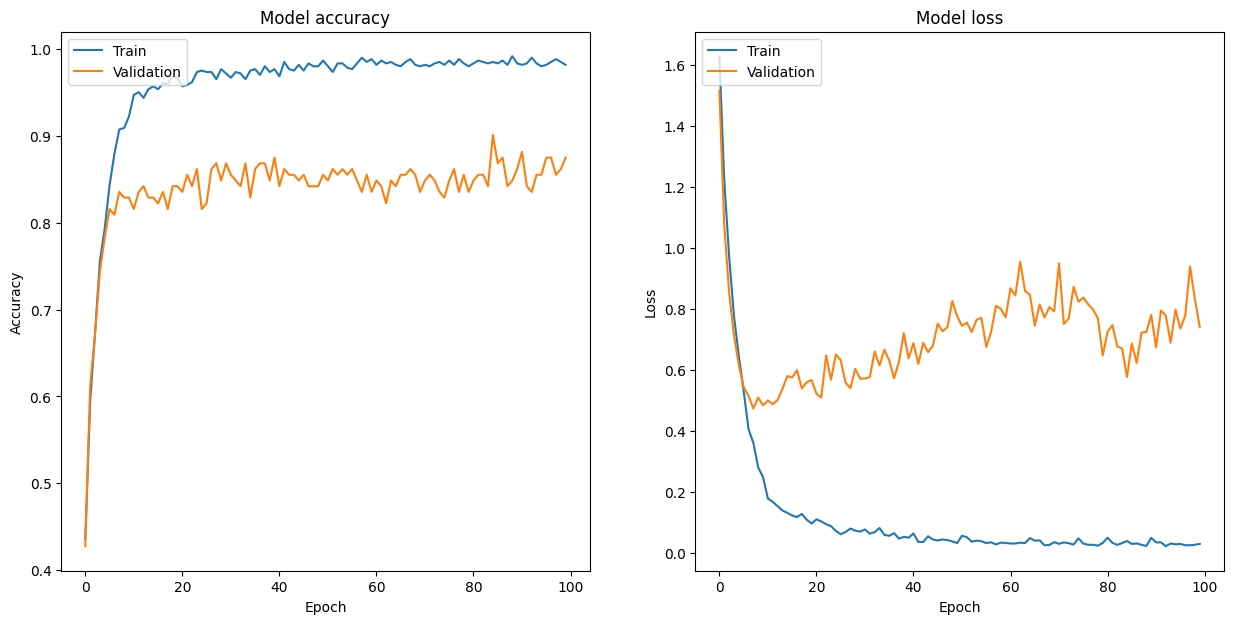

In [21]:
# Clear the values of previous plot
%matplotlib inline

fig = plt.figure(figsize=(15, 7))

# Plot training & validation accuracy values
fig.add_subplot(121)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('Training & Validation Accuracy Plot')

# Plot training & validation loss values
fig.add_subplot(122)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('Training & Validation Loss Plot')

In [22]:
model.load_weights(model_path)

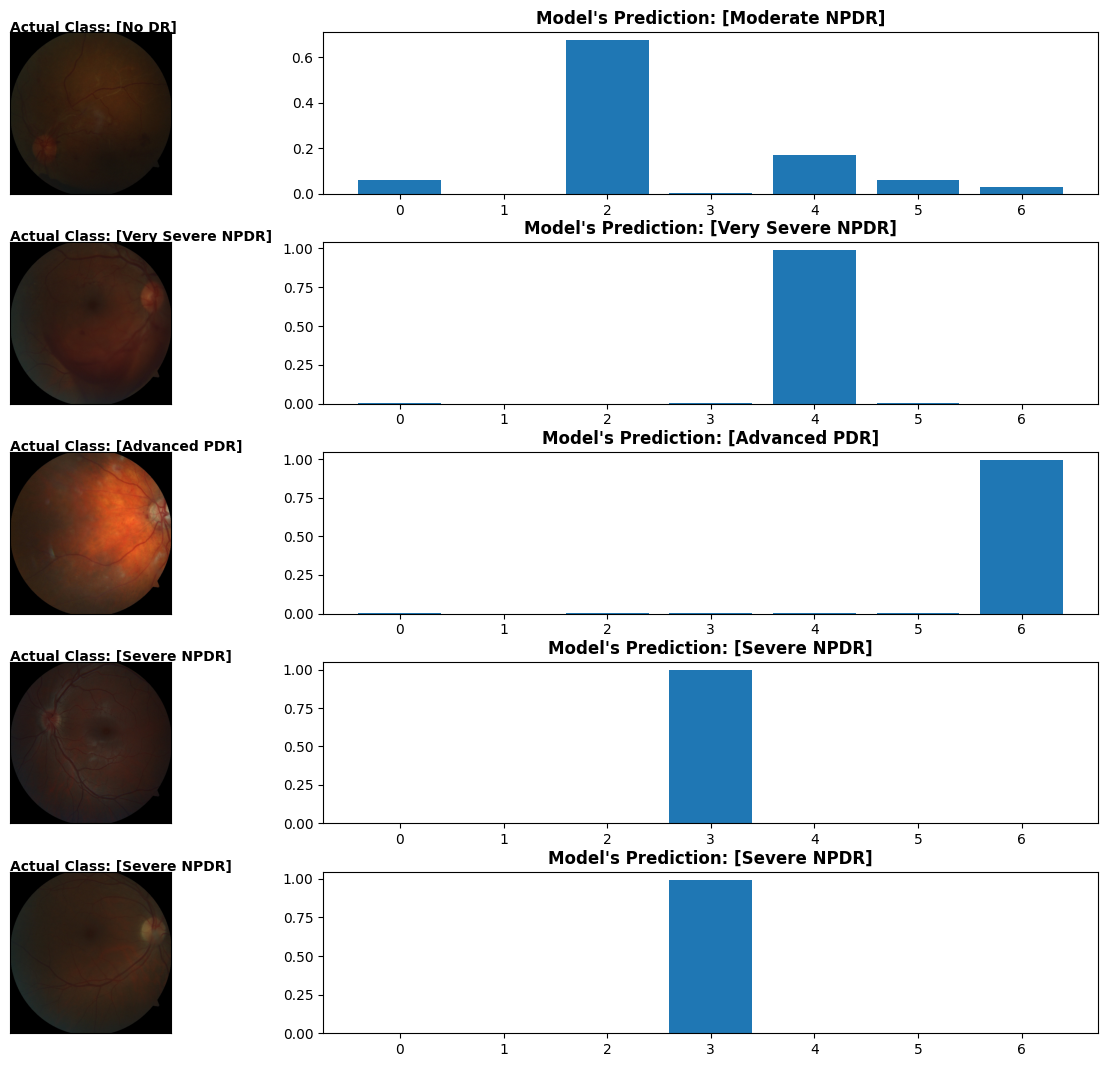

In [23]:
samples = np.random.choice(len(X_test), 5)

predictions = model.predict(X_test[samples], verbose=0)

fig, axes = plt.subplots(len(samples), 2, figsize=(18, 13))
fig.subplots_adjust(hspace=0.3, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, X_test[samples], y_test[samples])):

    axes[i, 0].imshow(np.squeeze(image/255.))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(1., -3, f'Actual Class: [{mapping[np.argmax(label)]}]', weight='bold')

    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_title(f"Model's Prediction: [{mapping[np.argmax(prediction)]}]", weight='bold')

In [24]:
y_score = model.predict(X_test)
y_pred = np.argmax(y_score,axis=-1)
Y_test = np.argmax(y_test,axis=-1)

5/5 [==============================] - 1s 119ms/step


In [25]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,cohen_kappa_score,roc_auc_score,confusion_matrix

acc = accuracy_score(Y_test,y_pred)
mpre = precision_score(Y_test,y_pred,average='macro')
mrecall = recall_score(Y_test,y_pred,average='macro')
mf1 = f1_score(Y_test,y_pred,average='macro')
kappa = cohen_kappa_score(Y_test,y_pred,weights='quadratic')
auc = roc_auc_score(Y_test, y_score, average='macro', multi_class='ovr')


print("Accuracy: ",round(acc*100,2))
print("Macro Precision: ",round(mpre*100,2))
print("Macro Recall: ",round(mrecall*100,2))
print("Macro F1-Score: ",round(mf1*100,2))
print("Quadratic Kappa Score: ",round(kappa*100,2))
print("ROC AUC Score: ",round(auc*100,2))

Accuracy:  90.13
Macro Precision:  88.78
Macro Recall:  88.4
Macro F1-Score:  88.49
Quadratic Kappa Score:  93.07
ROC AUC Score:  97.68


In [26]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9167    0.9565    0.9362        23
           1     1.0000    1.0000    1.0000         1
           2     0.8000    0.7500    0.7742        16
           3     0.9737    1.0000    0.9867        37
           4     0.6667    0.5556    0.6061        18
           5     0.9444    0.9714    0.9577        35
           6     0.9130    0.9545    0.9333        22

    accuracy                         0.9013       152
   macro avg     0.8878    0.8840    0.8849       152
weighted avg     0.8951    0.9013    0.8973       152



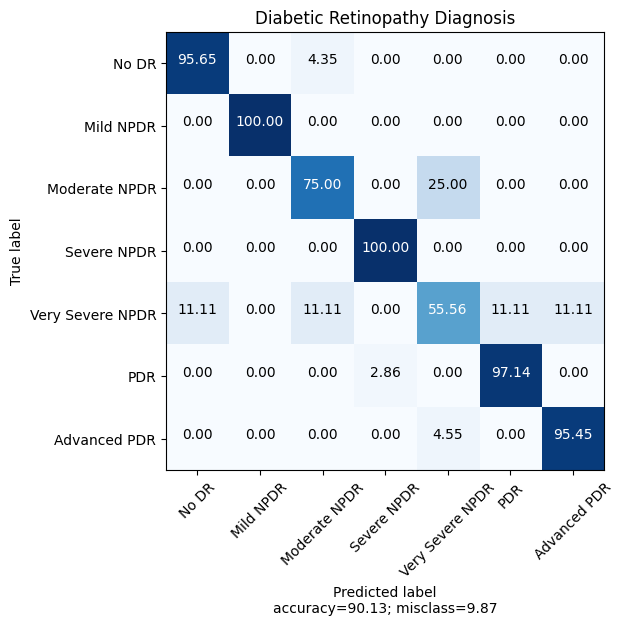

In [27]:
def plot_confusion_matrix(cm, target_names, title='Confusion Matrix', cmap=None, normalize=True):
    
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)


    #thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]*100),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.2f}; misclass={:0.2f}'.format(accuracy*100, misclass*100))
    plt.show()


# plot confusion matrix
cm = confusion_matrix(Y_test,y_pred)
targets = ['No DR', 'Mild NPDR', 'Moderate NPDR', 'Severe NPDR', 'Very Severe NPDR', 'PDR', 'Advanced PDR']
plot_confusion_matrix(cm, target_names = targets, title='Diabetic Retinopathy Diagnosis', cmap='Blues', normalize=True)

In [28]:
print("Confusion Matrix: \n", cm)

Confusion Matrix: 
 [[22  0  1  0  0  0  0]
 [ 0  1  0  0  0  0  0]
 [ 0  0 12  0  4  0  0]
 [ 0  0  0 37  0  0  0]
 [ 2  0  2  0 10  2  2]
 [ 0  0  0  1  0 34  0]
 [ 0  0  0  0  1  0 21]]


/tmp/ipykernel_3453/3994790778.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


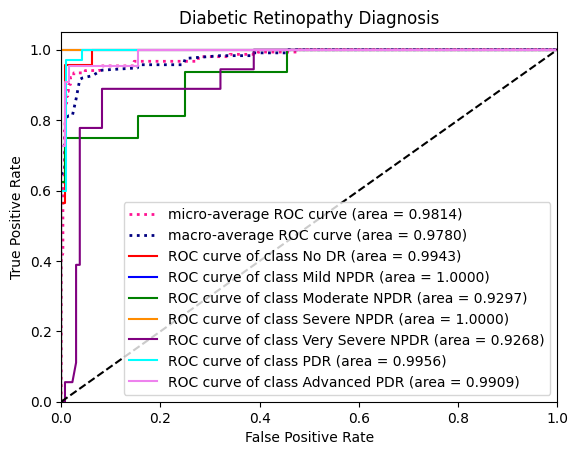

In [29]:
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

num_classes=7

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=2)

colors = cycle(['red','blue','green','darkorange', 'purple', 'cyan', 'violet', 'peru', 'black', 'gold'])
classes = ['No DR', 'Mild NPDR', 'Moderate NPDR', 'Severe NPDR', 'Very Severe NPDR', 'PDR', 'Advanced PDR']
lw = 1.5

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.4f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Diabetic Retinopathy Diagnosis')
plt.legend(loc="lower right")
plt.show()